In [1]:
# -*- coding: utf-8 -*-
"""rise_spatial_multiplicative_norm_zero_cineca.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1-4UndkKCTVbDRQZql3km54NZicEG05gb

### ***Cineca***
"""

import tensorflow as tf
#from tensorflow.keras import layers, activations, callbacks, models
import numpy as np
import pickle
import os
from keras.models import load_model
from skimage.transform import resize
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Save Execution Time
import datetime
import sys

"""
##### ***Data & Black-Box***

"""

RESULT_DIR = str(sys.argv[1])
print(f"RESULT_DIR: {RESULT_DIR}")

# IMPORTO I DATI PER VOTTIGNASCO
import os

# Ottieni il percorso effettivo da una variabile d'ambiente
#work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
#v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_OHE_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy"
#v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_image_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy"
#v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_target_dates_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy"
#v_test_normalization_factors_std_path  = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_std_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy"
#v_test_normalization_factors_mean_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")
v_test_normalization_factors_mean_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy"

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)
vott_target_test_std    = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean   = np.load(v_test_normalization_factors_mean_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

#print(vottingasco_test_OHE[0], "\n")
#print(vottignasco_test_image[0][0], "\n")

# """##### ***Black Boxes***""

# Se vuoi abilitare il dropout a runtime
mc_dropout = True

# Definizione della classe personalizzata doprout_custom
class doprout_custom(tf.keras.layers.SpatialDropout1D):
    def call(self, inputs, training=None):
        if mc_dropout:
            return super().call(inputs, training=True)
        else:
            return super().call(inputs, training=False)

# Percorso della directory su Cineca
base_dir = os.path.join(os.environ['WORK'], "Water_Resources/rise-video/trained_models/seq2val/Vottignasco")
lstm_suffix = 'time_dist_LSTM'

vott_lstm_models = []

def extract_index(filename):
    """Funzione per estrarre l'indice finale dal nome del file."""
    return int(filename.split('_LSTM_')[-1].split('.')[0])

# Trova tutti i file .keras nella cartella e li aggiunge alla lista
for filename in os.listdir(base_dir):
    if lstm_suffix in filename and filename.endswith(".keras"):
        vott_lstm_models.append(os.path.join(base_dir, filename))

# Ordina i modelli in base all'indice finale
vott_lstm_models = sorted(vott_lstm_models, key=lambda x: extract_index(os.path.basename(x)))

# Lista per i modelli caricati
vott_lstm_models_loaded = []

for i, model_lstm_path in enumerate(vott_lstm_models[:10]):  # Prendo i primi 10 modelli ordinati
    #print(f"Caricamento del modello LSTM {i+1}: {model_lstm_path}")

    # Carico il modello con la classe custom
    model = load_model(model_lstm_path, custom_objects={"doprout_custom": doprout_custom})

    # Aggiungo il modello alla lista
    vott_lstm_models_loaded.append(model)

print(vott_lstm_models_loaded)

"""### ***RISE-Spatio_Temporal***

#### ***Generation Masks (3D): Uniforme***
"""

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm

def generate_masks_3d(N, input_size, seed=42, **kwargs):
    """
    Parametri:
    - input_size: (t, h, w) -> dimensione finale della maschera 3D (time, Height, Width)
    """
    T, H, W = input_size
    l = kwargs.get("l", 8)   # Dimensione della small mask per il tempo
    h = kwargs.get("h", 2)
    w = kwargs.get("w", 4)
    p1 = kwargs.get("p1", 0.5)  # Probabilità di attivazione

    np.random.seed(seed)

    # Genera una maschera 3D casuale di dimensione (l, h,w)
    grid = np.random.rand(N, l, h, w) < p1
    grid = grid.astype('float32')

    # Struttura per le maschere finali di dimensione (N, T,H,W)
    masks = np.empty((N, T, H, W))

    # Coordinate per l'interpolazione spaziale
    grid_x = np.linspace(0, h - 1, h)
    grid_y = np.linspace(0, w - 1, w)
    grid_t = np.linspace(0, l - 1, l)

    for i in tqdm(range(N), desc='Generating masks'):
      # Crea un interpolatore per la maschera corrente
      interpolator = RegularGridInterpolator(
        (grid_t, grid_x, grid_y), grid[i], method='linear', bounds_error=False, fill_value=0
      )
      new_t = np.linspace(0, l - 1, T)
      new_x = np.linspace(0, h - 1, H)
      new_y = np.linspace(0, w - 1, W)
      mesh_t, mesh_x, mesh_y = np.meshgrid(new_t, new_x, new_y, indexing='ij')
      points = np.stack((mesh_t, mesh_x, mesh_y), axis=-1).reshape(-1, 3)
      interpolated_mask = interpolator(points)
      masks[i] = interpolated_mask.reshape(T, H, W)

    return masks

"""#### ***Application Masks***"""

def multiplicative_uniform_noise_onechannel(images, masks, channel, **kwargs):
    """
    Applica noise moltiplicativo continuo in 3D alle immagini sulla base delle maschere fornite.

    Parametri:
    - images: array di shape (104, 5, 8, C) -> serie temporale di immagini con canali multipli
    - masks: array di shape (N, 104, 5, 8) -> maschere continue con valori [0, 1]
    - channel: canale specifico su cui applicare il noise (0: Prec, 1: TMax, 2: TMin)
    - std_zero_value: valore del disturbo da applicare dove mask = 0
    """
    std_zero_value = kwargs.get("std_zero_value", -0.6486319166678826)

    masked = []

    # Itera su tutte le N maschere generate
    for mask in masks:
        masked_images = copy.deepcopy(images)  # Copia profonda delle immagini originali

        # Estrai solo il canale desiderato
        channel_values = masked_images[..., channel]

        # Applica la formula: v(p) + z (1-p)
        perturbed_values = channel_values * mask + (1 - mask) * std_zero_value

        # Sovrascrivi il canale con i valori perturbati
        masked_images[..., channel] = perturbed_values

        masked.append(masked_images)

    return masked

def ensemble_predict(models, images, x3_exp, batch_size=1000):
    # Assicuriamoci che images sia una lista
    if not isinstance(images, list):
        images = [images]

    len_x3 = len(images)

    # Convertiamo x3_exp in un tensore replicato per ogni immagine
    x3_exp_tensor = tf.convert_to_tensor(x3_exp, dtype=tf.float32)

    # Lista per raccogliere le predizioni finali
    final_preds = []

    # Processamento a batch
    for i in range(0, len_x3, batch_size):
        batch_images = images[i:i + batch_size]
        batch_len = len(batch_images)

        # Conversione batch in tensori
        Y_test = tf.stack([tf.convert_to_tensor(img, dtype=tf.float32) for img in batch_images])
        Y_test_x3 = tf.tile(tf.expand_dims(x3_exp_tensor, axis=0), [batch_len, 1, 1])

        # Raccoglie le predizioni di tutti i modelli per il batch corrente
        batch_preds = []

        for model in models:
            preds = model.predict([Y_test, Y_test_x3], verbose=0)
            batch_preds.append(preds)

        # Converte le predizioni del batch in un tensore e calcola la media
        batch_preds_tensor = tf.stack(batch_preds)
        mean_batch_preds = tf.reduce_mean(batch_preds_tensor, axis=0)

        # Aggiunge le predizioni del batch alla lista finale
        final_preds.extend(mean_batch_preds.numpy())

    return np.array(final_preds)

"""#### ***Saliency Map***"""

def calculate_saliency_map(N, weights, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.

    :param preds_array: Array di predizioni (numero di maschere x dimensioni predizione).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []
    H, W = masks.shape[2], masks.shape[3]
    for j in range(len(masks)):
        sal_i = weights[j] * masks[j]
        sal.append(sal_i.reshape(-1, H, W))  # Adatta la shape secondo il formato orginiale dei frame

    # Ora calcola la media lungo l'asse 0
    ev_masks = np.mean(masks, axis=0)
    
    sal = (1/(ev_masks * N)) * np.mean(sal, axis=0)

    return sal

2025-03-10 22:25:43.139204: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 22:25:45.843229: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 22:25:53.568021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 22:25:53.586612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 22:25:54.800436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

RESULT_DIR: --f=/run/user/128324/jupyter/runtime/kernel-v38a1b136d080a17ef8aa1cef9d542d0957f0b686d.json
105
105
105
[<keras.src.engine.functional.Functional object at 0x7fdae8e2aad0>, <keras.src.engine.functional.Functional object at 0x7fdae2486410>, <keras.src.engine.functional.Functional object at 0x7fdae21a41c0>, <keras.src.engine.functional.Functional object at 0x7fdae2224040>, <keras.src.engine.functional.Functional object at 0x7fdae2073a00>, <keras.src.engine.functional.Functional object at 0x7fdae20d50f0>, <keras.src.engine.functional.Functional object at 0x7fdae20d6380>, <keras.src.engine.functional.Functional object at 0x7fdae1f79b40>, <keras.src.engine.functional.Functional object at 0x7fdae1fe5f60>, <keras.src.engine.functional.Functional object at 0x7fdae1e60520>]


In [2]:
"""#### ***Evaluation Metrics***"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

import numpy as np

def get_flatten_saliency_video_ordered_by_importance(saliency_video):
    """
    Riceve un array 3D (T, H, W) con i valori di salienza e restituisce
    una lista ordinata dei pixel per importanza.

    :param saliency_video: np.array di shape (T, H, W) con i valori di salienza.
    :return: Lista ordinata di tuple (salienza, [t, x, y]), con la salienza decrescente.
    """
    # Flatten dei valori di salienza
    flatten_saliency_video = saliency_video.flatten()

    # Ottieni gli indici originali [t, x, y] per ogni pixel
    indices = np.array(np.unravel_index(np.arange(flatten_saliency_video.size), saliency_video.shape)).T

    # Combina valori e indici: lista di tuple (salienza, [t, x, y])
    saliency_video_value_with_indices = list(zip(flatten_saliency_video, indices))

    # Ordina per valore di salienza (decrescente) e, a parità, per le coordinate (decrescente)
    sorted_saliency = sorted(
        saliency_video_value_with_indices,
        key=lambda x: (x[0], -x[1][0], -x[1][1], -x[1][2]),
        reverse=True
    )

    return sorted_saliency


def plot_insertion_curve(total_errors, auc, title="Insertion Metric Curve"):
    """
    Plotta la curva di metrica di insertion con l'errore medio quadratico.

    :param total_errors: Lista dei valori dell'errore per ogni frazione di pixel inseriti.
    :param auc: Valore dell'Area Under Curve (AUC) calcolato.
    :param title: Titolo del grafico (default: "Insertion Metric Curve").
    """

    # Nuovo asse X normalizzato tra 0 e 1
    x = np.linspace(0, 1, len(total_errors))

    # Plot della curva dell'errore e dell'area sotto la curva (AUC)
    plt.figure(figsize=(7, 5))
    plt.plot(x, total_errors, linestyle='-', color='blue')

    # Area sotto la curva
    plt.fill_between(x, total_errors, color='skyblue', alpha=0.4)

    # Testo "Error curve" in alto a dx con font più piccolo
    plt.legend(['Error curve'], loc='upper right', fontsize=9)

    # Testo AUC appena sotto "Error curve"
    plt.text(x[-1] - 0.02, max(total_errors) * 0.9,
             f'AUC: {auc:.2f}',
             horizontalalignment='right',
             fontsize=8,
             bbox=dict(facecolor='white', alpha=0.5))

    # Etichette assi
    plt.xlabel('Fraction of pixels inserted')
    plt.ylabel('Mean Squared Error')

    # Titolo del grafico
    plt.title(title)

    # Mostra il grafico
    plt.show()


def plot_deletion_curve(total_errors, auc, title="Deletion Metric Curve"):
    """
    Plotta la curva della metrica di deletion con l'errore medio quadratico.

    :param total_errors: Lista dei valori dell'errore per ogni frazione di pixel rimossi.
    :param auc: Valore dell'Area Under Curve (AUC) calcolato.
    :param title: Titolo del grafico (default: "Deletion Metric Curve").
    """

    # Normalizzazione dell'asse X tra 0 e 1
    x = np.linspace(0, 1, len(total_errors))

    # Creazione del plot
    plt.figure(figsize=(7,5))
    plt.plot(x, total_errors, linestyle='-', color='red')

    # Area sotto la curva
    plt.fill_between(x, total_errors, color='lightcoral', alpha=0.4)

    # Testo "Error curve" in alto a sx con font più piccolo
    plt.legend(['Error curve'], loc='lower right',  bbox_to_anchor=(0.97, 0.02))

    # Testo AUC leggermente spostato sotto la legenda
    plt.text(0.941, 0.13, f'AUC: {auc:.2f}',
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='grey'))

    # Etichette degli assi
    plt.xlabel('Fraction of pixels removed')
    plt.ylabel('Mean Squared Error')

    # Titolo del grafico
    plt.title(title)

    # Mostra il grafico
    plt.show()

"""##### ***Insertion***"""

def update_instance_with_pixels(current_instance, original_instance, t,x,y):
    """
    Aggiorna l'immagine inserendo i pixel più importanti.

    :param current_instance: Istanza corrente.
    :param original_instance: Istanza originale.
    :param t: coordinata t del pixel da inserire
    :param x: coordinata x del pixel da inserire
    :param y: coordinata y del pixel da inserire
    :return: Istanza aggiornata con il superpixel.
    """
    new_current_instance = current_instance.copy()
    new_current_instance[t, x, y, 0] = original_instance[t, x, y, 0]

    return new_current_instance


def insertion(model, original_instance, x3_instance, sorted_per_importance_pixels_index, initial_blurred_instance, original_prediction, H_station=390.0):
    """
    Calcola la metrica di inserimento per una spiegazione data.

    :param model: Black-box.
    :param original_instance: Istanza originale.
    :param sorted_per_importance_pixels_index: Lista di liste di tutti i superpixel per importanza
    :param initial_blurred_images: Immagine iniziale con tutti i pixel a zero.
    :return: Lista degli errori ad ogni passo di inserimento.
    """

    # Lista per memorizzare le istanze a cui aggiungo pixel mano a mano. Inizializzata con istanza iniziale blurrata
    insertion_images = [initial_blurred_instance]

    # Predizione sull'immagine iniziale (tutti i pixel a zero)
    I_prime = copy.deepcopy(initial_blurred_instance)

    # Aggiungere gradualmente i pixel (per ogni frame) più importanti. Ottengo una lista con tutte le img con i pixel aggiunti in maniera graduale
    for t,x,y in sorted_per_importance_pixels_index:
        I_prime = update_instance_with_pixels(I_prime, original_instance, t,x,y)
        insertion_images.append(I_prime)

    insertion_images = [img.astype(np.float32) for img in insertion_images]
    # Calcolo le predizioni sulle istanze a cui ho aggiunto i pixel in maniera graduale
    new_predictions = ensemble_predict(model, insertion_images, x3_instance)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Rispetto ad ogni suddetta predizione, calcolo il MSE rispetto la pred sull'istanza originaria (come da test-set). Ignora la prima che è sull'img blurrata originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions[1:]]

    initial_error = mean_squared_error(original_prediction, denormalized_H_new_predictions[0])
    print(f"Initial Prediction with Blurred Instance. Prediction: {denormalized_H_new_predictions[0]}, error: {initial_error}")
    
    only_inserted_pixel_new_predictions = denormalized_H_new_predictions[1:]
    for nr_pixel, error in enumerate(errors):
      print(f"Inserted Pixel: {sorted_per_importance_pixels_index[nr_pixel]}. Prediction: {only_inserted_pixel_new_predictions[nr_pixel]}, error: {error}")

    total_errors = [initial_error] + errors # Errore iniziale + errori su tutti i pixel inseriti

    # # Nuovo asse X
    x = np.linspace(0, 1, len(total_errors))
    # Calcolo dell'AUC con il nuovo asse x
    auc = calculate_auc(x, total_errors)
    print(f"Area under the curve (AUC): {auc}")
    return total_errors,auc

"""##### ***Deletion***"""

def update_image_by_removing_pixels(current_instance, t, x, y, std_zero_value=-0.6486319166678826):
    """
    Aggiorna l'immagine rimuovendo i pixel x,y indicati.

    :param current_instance: istanza corrente.
    :param t: coordinata t del pixel da rimuovere
    :param x: coordinata x del pixel da rimuovere
    :param y: coordinata y del pixel da rimuovere
    :return: Istanza aggiornata con x,y rimossi su tutti time-step.
    """
    new_instance = copy.deepcopy(current_instance)
    new_instance[t, x, y, 0] = std_zero_value # Imposta i pixel a zero normalizzato per Prec
    # new_instance[t, x, y, 1] = 0.0 # Imposta i pixel a zero per Tmax
    # new_instance[t, x, y, 2] = 0.0 # Imposta i pixel a zero per Tmin
    return new_instance


def deletion(models, original_instance, x3_instance, sorted_per_importance_pixels_index, original_prediction, H_station=390.0):
    """
    Calcola la metrica di rimozione per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_instance: Immagine originale.
    :param x3_instance: Codifica one-hot per la previsione.
    :param sorted_per_importance_pixels_index: Indici dei pixel in ordine di importanza.
    :return: Lista degli errori, auc ad ogni passo di rimozione.
    """
    # Lista per memorizzare le img a cui elimino gradualmente i pixels (per ogni time-step)
    deletion_images = []

    # Inizializzazione
    I_prime = copy.deepcopy(original_instance)

    # Aggiungere gradualmente i pixel (per ogni frame) più importanti. Ottengo una lista con tutte le img con i pixel rimossi
    for t,x,y in sorted_per_importance_pixels_index:
        I_prime = update_image_by_removing_pixels(I_prime, t, x, y)
        deletion_images.append(I_prime)

    # Calcolo della predizione su tutte le img a cui ho rimosso gradualmente i pixel
    new_predictions = ensemble_predict(models, deletion_images, x3_instance)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Calcolo del mse rispetto la predizione originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions]

    initial_error = 0.0
    print(f"Initial Prediction with Original Images, prediction: {original_prediction}, error: {initial_error}")

    #for nr_pixel, error in enumerate(errors):
    #    print(f"Removed pixel {sorted_per_importance_pixels_index[nr_pixel]}, new prediction: {denormalized_H_new_predictions[nr_pixel]}, error: {error}")

    total_errors = [initial_error] + errors  # Errore iniziale + errori su tutti i pixel rimossi

    # Normalizzare la frazione di pixel rimossi
    x = np.linspace(0, 1, len(total_errors))
    # Calcolo dell'AUC
    auc = calculate_auc(x, total_errors)

    print(f"Area under the curve (AUC): {auc}")
    return total_errors, auc

In [3]:
"""#### ***Spatio_Temporal-RISE: Framework***"""

def rise_st_explain(nr_instance, data_test_image, data_test_OHE, models, channel,
                    N, generate_masks_fn, seed, perturb_instance_fn, calculate_saliency_map_fn, H_station=390.0, **kwargs):
  print(f"############################### RISE-Temporal on Instance #{nr_instance} ###########################")
  instance    = copy.deepcopy(data_test_image[nr_instance])
  x3_instance = copy.deepcopy(data_test_OHE[nr_instance])

  input_size = (instance.shape[0], instance.shape[1], instance.shape[2])

  masks = generate_masks_fn(N, input_size, seed, **kwargs)
  perturbed_instances = perturb_instance_fn(instance, masks, channel)

  # Predizione su Istanza Originale
  pred_original = ensemble_predict(models, instance, x3_instance)
  # Predizioni su Istanze Perturbate
  preds_masked = ensemble_predict(models, perturbed_instances, x3_instance)
  # Denormalizzazione con H_station (altezza della stazione)
  denorm_pred_original = pred_original * vott_target_test_std + vott_target_test_mean
  denorm_preds_masked  = [pred_masked * vott_target_test_std + vott_target_test_mean for pred_masked in preds_masked]
  denormalized_H_pred_original = H_station - denorm_pred_original
  denormalized_H_preds_masked  = [H_station - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]

  # Pesi delle Maschere
  weights = np.concatenate(denormalized_H_preds_masked, axis=0)

  ### S1 
  s1_i = calculate_saliency_map_fn(N, weights, masks)
  ### S2
  s2_i = calculate_saliency_map_fn(N, weights**2, masks) - (s1_i**2)
  ### S3 (BIAS)
  s3_i = (s1_i - denormalized_H_pred_original)
  ### S4 (RMSE)
  s4_i = np.sqrt((s3_i**2) + s2_i)

  print(f"############### Processo completato. Mappa di salienza generata per Istanza #{nr_instance} ###############")
  return np.squeeze(s1_i), np.squeeze(s2_i), np.squeeze(s3_i), np.squeeze(s4_i)

In [7]:
nr_instance = 0
instance    = copy.deepcopy(vottignasco_test_image[nr_instance])
sample_mask = generate_masks_3d(30, (instance.shape[0], instance.shape[1], instance.shape[2]), 42)

Generating masks: 100%|██████████| 30/30 [00:00<00:00, 1472.25it/s]


In [8]:
sample_mask.shape

(30, 104, 5, 8)

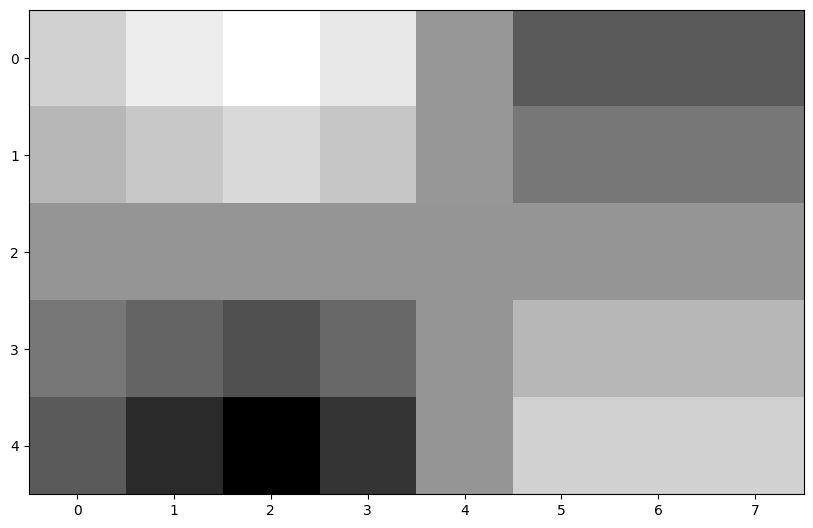

In [40]:
plt.subplots(figsize = (10,10))
plt.imshow(sample_mask[1, 25, :, :], cmap = "Greys")
plt.show()

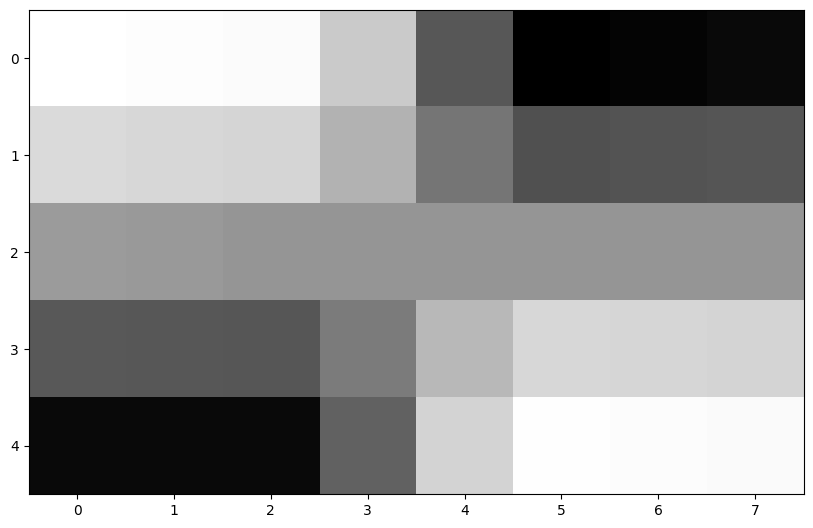

In [39]:
plt.subplots(figsize = (10,10))
plt.imshow(sample_mask[1, 30, :, :], cmap = "Greys")
plt.show()

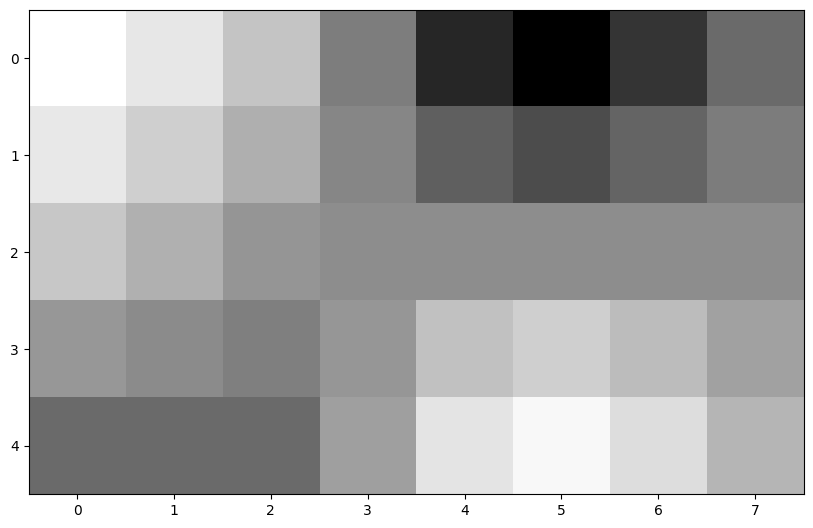

In [41]:
plt.subplots(figsize = (10,10))
plt.imshow(sample_mask[1, 35, :, :], cmap = "Greys")
plt.show()

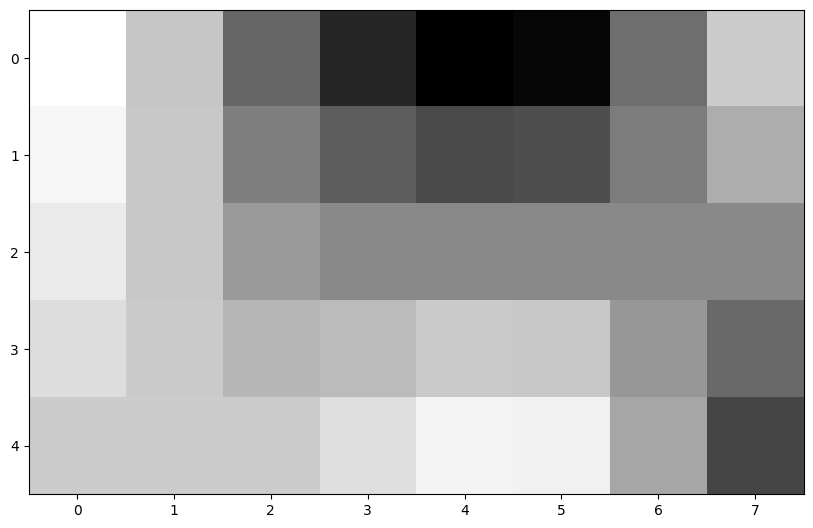

In [43]:
plt.subplots(figsize = (10,10))
plt.imshow(sample_mask[1, 40, :, :], cmap = "Greys")
plt.show()

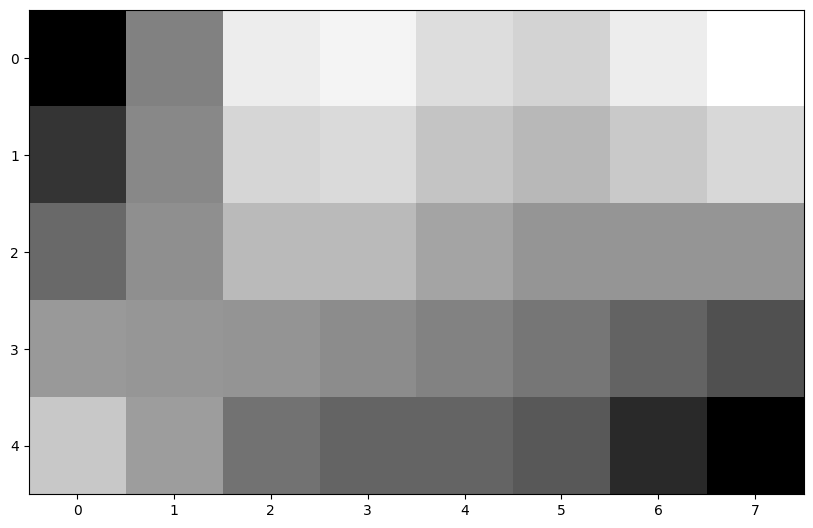

In [44]:
plt.subplots(figsize = (10,10))
plt.imshow(sample_mask[1, 10, :, :], cmap = "Greys")
plt.show()

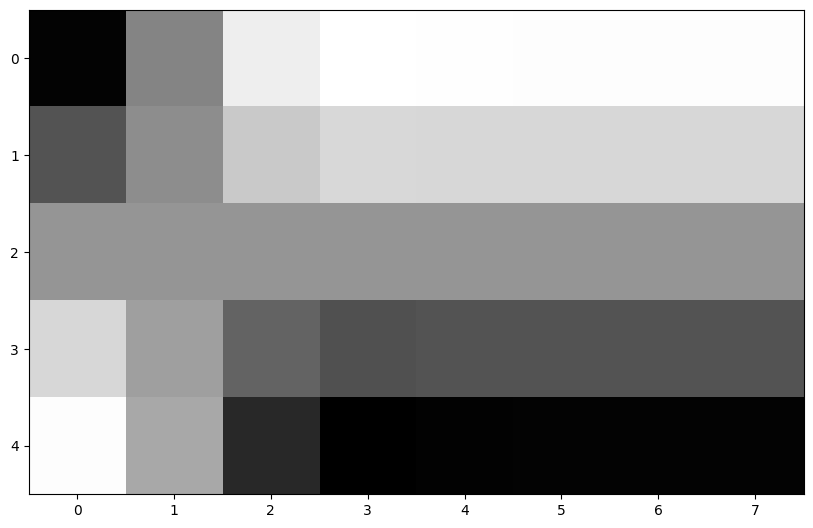

In [45]:
plt.subplots(figsize = (10,10))
plt.imshow(sample_mask[1, 15, :, :], cmap = "Greys")
plt.show()

In [4]:
"""### ***Experiments***"""

channel_prec = 0
models = vott_lstm_models_loaded
seed = 42
T,H,W,C = (104,5,8,3)
std_zero_value = -0.6486319166678826
H_station = 390.0

N = 10

l_values = [10]
h_w_values = [(2,4)]
p_values = [0.5]
#p_values = [0.5, 0.6, 0.7, 0.8, 0.9]

len_test_set = len(vottignasco_test_image)

##### Mock 

mock_vott_test_image = [copy.deepcopy(vottignasco_test_image[0])]
len_test_set = len(mock_vott_test_image)

for nr_setup,l in enumerate(l_values):
  print(f"############################## Setup #{nr_setup} ##############################")
  for h,w in h_w_values:
    for _, p in enumerate(p_values):
      # Conserva tutte i sal_video per tutto il Test-Set
      saliency_videos = np.zeros((len_test_set,4, T, H, W))
       # Errori e AUC Insertion/Deletion tutto il Test-Set
      errors_insertion_all_testset = np.zeros((len_test_set,4, (T*H*W)+1))   # (105, 4160+1)
      auc_insertion_all_testset    = np.zeros((len_test_set,4, 1))           # (105, 1)
      errors_deletion_all_testset  = np.zeros((len_test_set,4, (T*H*W)+1))   # (105, 4160+1)
      auc_deletion_all_testset     = np.zeros((len_test_set,4, 1))           # (105, 1)

      nr_p = str(p).replace('.','')
      
      param_combination = f"l_{l}_h{h}_w{w}_p_{nr_p}"

      print(f"############################## Parameters Combination: {param_combination} ##############################")
      execution_times = []
      #for nr_instance,_ in enumerate(vottignasco_test_image):
      for nr_instance,_ in enumerate(mock_vott_test_image):
        print(f"###################### Explanation for Instance #{nr_instance} ####################################")
        time_start = datetime.datetime.now()

        s1_i,s2_i,s3_i,s4_i = rise_st_explain(nr_instance, vottignasco_test_image, vottignasco_test_OHE, models, channel_prec,
                                              N, generate_masks_3d, seed, multiplicative_uniform_noise_onechannel, calculate_saliency_map, l=l, h=h, w=w, p1=p)

        time_end = datetime.datetime.now()
        exec_time = (time_end - time_start).total_seconds()

        execution_times.append(exec_time)

        saliency_videos[nr_instance][0] = s1_i
        saliency_videos[nr_instance][1] = s2_i
        saliency_videos[nr_instance][2] = s3_i
        saliency_videos[nr_instance][3] = s4_i

        instance    = copy.deepcopy(vottignasco_test_image[nr_instance])
        x3_instance = copy.deepcopy(vottignasco_test_OHE[nr_instance])

        # Insertion s2,s3,s4
        # Video blurrato da cui partire per l'Insertion. Tutti i pixel di Prec su std_zero_value
        initial_blurred_instance = copy.deepcopy(instance)
        initial_blurred_instance[:,:,:,channel_prec] = std_zero_value

        original_instance = copy.deepcopy(instance)
        original_prediction = ensemble_predict(models, original_instance, x3_instance)
        denormalized_H_original_prediction = H_station - (original_prediction * vott_target_test_std + vott_target_test_mean)
        print(f"Original Prediction: {denormalized_H_original_prediction}")

        all_important_pixels_s2 = get_flatten_saliency_video_ordered_by_importance(s2_i)[::-1] # Valori più "importanti" prossimi allo 0
        all_important_pixels_s2 = [coord for _,coord in all_important_pixels_s2]

        all_important_pixels_s3 = get_flatten_saliency_video_ordered_by_importance(np.abs(s3_i))[::-1]
        all_important_pixels_s3 = [coord for _,coord in all_important_pixels_s3]

        all_important_pixels_s4 = get_flatten_saliency_video_ordered_by_importance(s4_i)[::-1]
        all_important_pixels_s4 = [coord for _,coord in all_important_pixels_s4]

        # Insertion
        errors_insertion_s2,auc_insertion_s2 = insertion(models, original_instance, x3_instance, all_important_pixels_s2, initial_blurred_instance, denormalized_H_original_prediction) # s2   
        errors_insertion_s3,auc_insertion_s3 = insertion(models, original_instance, x3_instance, all_important_pixels_s3, initial_blurred_instance, denormalized_H_original_prediction) # s3
        errors_insertion_s4,auc_insertion_s4 = insertion(models, original_instance, x3_instance, all_important_pixels_s4, initial_blurred_instance, denormalized_H_original_prediction) # s4

        for nr_error in range (0, (T*H*W)+1):
          errors_insertion_all_testset[nr_instance][1][nr_error] = errors_insertion_s2[nr_error]
          errors_insertion_all_testset[nr_instance][2][nr_error] = errors_insertion_s3[nr_error]
          errors_insertion_all_testset[nr_instance][3][nr_error] = errors_insertion_s4[nr_error]

        auc_insertion_all_testset[nr_instance][1] = auc_insertion_s2
        auc_insertion_all_testset[nr_instance][2] = auc_insertion_s3
        auc_insertion_all_testset[nr_instance][3] = auc_insertion_s4

        # Deletion
        errors_deletion_s2,auc_deletion_s2 = deletion(models, original_instance, x3_instance, all_important_pixels_s2, denormalized_H_original_prediction) # s2
        errors_deletion_s3,auc_deletion_s3 = deletion(models, original_instance, x3_instance, all_important_pixels_s3, denormalized_H_original_prediction) # s3
        errors_deletion_s4,auc_deletion_s4 = deletion(models, original_instance, x3_instance, all_important_pixels_s4, denormalized_H_original_prediction) # s4

        for nr_error in range (0, (T*H*W)+1):
          errors_deletion_all_testset[nr_instance][1][nr_error] = errors_deletion_s2[nr_error]
          errors_deletion_all_testset[nr_instance][2][nr_error] = errors_deletion_s3[nr_error]
          errors_deletion_all_testset[nr_instance][3][nr_error] = errors_deletion_s4[nr_error]

        auc_deletion_all_testset[nr_instance][1] = auc_deletion_s2
        auc_deletion_all_testset[nr_instance][2] = auc_deletion_s3
        auc_deletion_all_testset[nr_instance][3] = auc_deletion_s4

      print(f"#################################### END for all Instance in Test-Set for {param_combination} ####################################")

      result = {
        "saliency_videos": saliency_videos,
        "errors_insertion": errors_insertion_all_testset,
        "auc_insertion": auc_insertion_all_testset,
        "errors_deletion": errors_deletion_all_testset,
        "auc_deletion": auc_deletion_all_testset,
        "parameters_comb": param_combination,
        "execution_times": execution_times  # Lista di nr_instances (105) tempi di exec per ogni istanza
      }

      #path_to_save_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/spatial_temporal/results//test_st_results_setup_{param_combination}.pkl")
      path_to_save_results = f"{RESULT_DIR}/rise_st_original_result_setup_{param_combination}.pkl"
      # Salvataggio della lista results in un file pickle
      with open(path_to_save_results, 'wb') as f:
        pickle.dump(result, f)

print("############################# END FOR ALL SETUPS ##########################################################################")


############################## Setup #0 ##############################
############################## Parameters Combination: l_10_h2_w4_p_05 ##############################
###################### Explanation for Instance #0 ####################################
############################### RISE-Temporal on Instance #0 ###########################


Generating masks: 100%|██████████| 10/10 [00:00<00:00, 122.07it/s]


############### Processo completato. Mappa di salienza generata per Istanza #0 ###############
Original Prediction: [[385.45544]]
Initial Prediction with Blurred Instance. Prediction: [384.09106], error: 1.86153244972229
Inserted Pixel: [11  0  0]. Prediction: [384.0628], error: 1.939443826675415
Inserted Pixel: [12  0  0]. Prediction: [384.04868], error: 1.9789984226226807
Inserted Pixel: [46  4  0]. Prediction: [383.99414], error: 2.135408639907837
Inserted Pixel: [10  0  0]. Prediction: [383.89523], error: 2.4342589378356934
Inserted Pixel: [47  4  0]. Prediction: [384.03372], error: 2.021294593811035
Inserted Pixel: [9 0 0]. Prediction: [383.9782], error: 2.182219982147217
Inserted Pixel: [45  4  0]. Prediction: [383.97946], error: 2.1785247325897217
Inserted Pixel: [23  4  2]. Prediction: [384.09695], error: 1.8454951047897339
Inserted Pixel: [22  4  2]. Prediction: [383.97952], error: 2.1783447265625
Inserted Pixel: [13  0  0]. Prediction: [384.09787], error: 1.8430083990097046
I

: 

In [ ]:
masks.shape

: 

In [11]:
path_to_load_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/spatial_temporal/results//test_st_results_setup_{param_combination}.pkl")
      #path_to_save_results = f"{RESULT_DIR}/rise_st_original_result_setup_{param_combination}.pkl"
      # Salvataggio della lista results in un file pickle
with open(path_to_load_results, 'rb') as f:
   result = pickle.load(f)

In [16]:
result["saliency_videos"][0][3]

array([[[365.66374806, 365.66374196, 365.6637342 , ..., 365.66372383,
         365.66371899, 365.66371416],
        [365.6637382 , 365.66373572, 365.66373185, ..., 365.66372541,
         365.66372046, 365.66371484],
        [365.66373103, 365.66373044, 365.66372933, ..., 365.66372677,
         365.66372188, 365.66371559],
        [365.66372558, 365.66372591, 365.66372663, ..., 365.66372797,
         365.66372327, 365.66371644],
        [365.6637213 , 365.66372197, 365.6637237 , ..., 365.66372902,
         365.66372462, 365.66371738]],

       [[365.66374779, 365.66374182, 365.66373486, ..., 365.66372636,
         365.66372031, 365.66371369],
        [365.66373812, 365.6637358 , 365.66373251, ..., 365.66372759,
         365.66372199, 365.66371529],
        [365.66373095, 365.66373059, 365.66372999, ..., 365.66372868,
         365.6637236 , 365.66371698],
        [365.66372543, 365.66372604, 365.66372726, ..., 365.66372965,
         365.66372514, 365.66371877],
        [365.66372104, 365

### NEW S1,S2,S3,S4

In [16]:
# -*- coding: utf-8 -*-
"""rise_spatial_multiplicative_norm_zero_cineca.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1-4UndkKCTVbDRQZql3km54NZicEG05gb

### ***Cineca***
"""

import tensorflow as tf
#from tensorflow.keras import layers, activations, callbacks, models
import numpy as np
import pickle
import os
from keras.models import load_model
from skimage.transform import resize
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Save Execution Time
import datetime
import sys

"""
##### ***Data & Black-Box***

"""

RESULT_DIR = str(sys.argv[1])
print(f"RESULT_DIR: {RESULT_DIR}")

# IMPORTO I DATI PER VOTTIGNASCO
import os

# Ottieni il percorso effettivo da una variabile d'ambiente
#work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
#v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_OHE_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy"
#v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_image_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy"
#v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_target_dates_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy"
#v_test_normalization_factors_std_path  = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_std_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy"
#v_test_normalization_factors_mean_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")
v_test_normalization_factors_mean_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy"

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)
vott_target_test_std    = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean   = np.load(v_test_normalization_factors_mean_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

#print(vottingasco_test_OHE[0], "\n")
#print(vottignasco_test_image[0][0], "\n")

# """##### ***Black Boxes***""

# Se vuoi abilitare il dropout a runtime
mc_dropout = True

# Definizione della classe personalizzata doprout_custom
class doprout_custom(tf.keras.layers.SpatialDropout1D):
    def call(self, inputs, training=None):
        if mc_dropout:
            return super().call(inputs, training=True)
        else:
            return super().call(inputs, training=False)

# Percorso della directory su Cineca
#base_dir = os.path.join(os.environ['WORK'], "Water_Resources/rise-video/trained_models/seq2val/Vottignasco")
base_dir  = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/trained_models/seq2val/Vottignasco"
lstm_suffix = 'time_dist_LSTM'

vott_lstm_models = []

def extract_index(filename):
    """Funzione per estrarre l'indice finale dal nome del file."""
    return int(filename.split('_LSTM_')[-1].split('.')[0])

# Trova tutti i file .keras nella cartella e li aggiunge alla lista
for filename in os.listdir(base_dir):
    if lstm_suffix in filename and filename.endswith(".keras"):
        vott_lstm_models.append(os.path.join(base_dir, filename))

# Ordina i modelli in base all'indice finale
vott_lstm_models = sorted(vott_lstm_models, key=lambda x: extract_index(os.path.basename(x)))

# Lista per i modelli caricati
vott_lstm_models_loaded = []

for i, model_lstm_path in enumerate(vott_lstm_models[:10]):  # Prendo i primi 10 modelli ordinati
    #print(f"Caricamento del modello LSTM {i+1}: {model_lstm_path}")

    # Carico il modello con la classe custom
    model = load_model(model_lstm_path, custom_objects={"doprout_custom": doprout_custom})

    # Aggiungo il modello alla lista
    vott_lstm_models_loaded.append(model)

print(vott_lstm_models_loaded)


RESULT_DIR: --f=/run/user/129071/jupyter/runtime/kernel-v3bc8a6c06b700bbeb9a8297c048750d6ad4801fae.json
105
105
105
[<keras.src.engine.functional.Functional object at 0x7f0bf5cd81c0>, <keras.src.engine.functional.Functional object at 0x7f0bf7ac6b60>, <keras.src.engine.functional.Functional object at 0x7f0bf6075030>, <keras.src.engine.functional.Functional object at 0x7f0bf663db70>, <keras.src.engine.functional.Functional object at 0x7f0bf5b48370>, <keras.src.engine.functional.Functional object at 0x7f0bf589dea0>, <keras.src.engine.functional.Functional object at 0x7f0bfe339900>, <keras.src.engine.functional.Functional object at 0x7f0bfe3474f0>, <keras.src.engine.functional.Functional object at 0x7f0bfe3c5a80>, <keras.src.engine.functional.Functional object at 0x7f0bfe246f50>]


In [17]:
"""### ***RISE-Spatio_Temporal***

#### ***Generation Masks (3D): Uniforme***
"""

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm


def generate_masks_3d(N, input_size, seed=42, **kwargs):
    """
    Parametri:
    - input_size: (t, h, w) -> dimensione finale della maschera 3D (time, Height, Width)
    """
    T, H, W = input_size
    l = kwargs.get("l", 8)   # Dimensione della small mask per il tempo
    h = kwargs.get("h", 2)
    w = kwargs.get("w", 4)
    p1 = kwargs.get("p1", 0.5)  # Probabilità di attivazione

    np.random.seed(seed)

    # Genera una maschera 3D casuale di dimensione (l, h,w)
    grid = np.random.rand(N, l, h, w) < p1
    grid = grid.astype('float32')

    # Struttura per le maschere finali di dimensione (N, T,H,W)
    masks = np.empty((N, T, H, W))

    # Coordinate per l'interpolazione spaziale
    grid_x = np.linspace(0, h - 1, h)
    grid_y = np.linspace(0, w - 1, w)
    grid_t = np.linspace(0, l - 1, l)

    for i in tqdm(range(N), desc='Generating masks'):
      # Crea un interpolatore per la maschera corrente
      interpolator = RegularGridInterpolator(
        (grid_t, grid_x, grid_y), grid[i], method='linear', bounds_error=False, fill_value=0
      )
      new_t = np.linspace(0, l - 1, T)
      new_x = np.linspace(0, h - 1, H)
      new_y = np.linspace(0, w - 1, W)
      mesh_t, mesh_x, mesh_y = np.meshgrid(new_t, new_x, new_y, indexing='ij')
      points = np.stack((mesh_t, mesh_x, mesh_y), axis=-1).reshape(-1, 3)
      interpolated_mask = interpolator(points)
      masks[i] = interpolated_mask.reshape(T, H, W)

    return masks

"""#### ***Application Masks***"""

def multiplicative_uniform_noise_onechannel(images, masks, channel, **kwargs):
    """
    Applica noise moltiplicativo continuo in 3D alle immagini sulla base delle maschere fornite.

    Parametri:
    - images: array di shape (104, 5, 8, C) -> serie temporale di immagini con canali multipli
    - masks: array di shape (N, 104, 5, 8) -> maschere continue con valori [0, 1]
    - channel: canale specifico su cui applicare il noise (0: Prec, 1: TMax, 2: TMin)
    - std_zero_value: valore del disturbo da applicare dove mask = 0
    """
    std_zero_value = kwargs.get("std_zero_value", -0.6486319166678826)

    masked = []

    # Itera su tutte le N maschere generate
    for mask in masks:
        masked_images = copy.deepcopy(images)  # Copia profonda delle immagini originali

        # Estrai solo il canale desiderato
        channel_values = masked_images[..., channel]

        # Applica la formula: v(p) + z (1-p)
        perturbed_values = channel_values * mask + (1 - mask) * std_zero_value

        # Sovrascrivi il canale con i valori perturbati
        masked_images[..., channel] = perturbed_values

        masked.append(masked_images)

    return masked

def ensemble_predict(models, images, x3_exp, batch_size=1000):
    # Assicuriamoci che images sia una lista
    if not isinstance(images, list):
        images = [images]

    len_x3 = len(images)

    # Convertiamo x3_exp in un tensore replicato per ogni immagine
    x3_exp_tensor = tf.convert_to_tensor(x3_exp, dtype=tf.float32)

    # Lista per raccogliere le predizioni finali
    final_preds = []

    # Processamento a batch
    for i in range(0, len_x3, batch_size):
        batch_images = images[i:i + batch_size]
        batch_len = len(batch_images)

        # Conversione batch in tensori
        Y_test = tf.stack([tf.convert_to_tensor(img, dtype=tf.float32) for img in batch_images])
        Y_test_x3 = tf.tile(tf.expand_dims(x3_exp_tensor, axis=0), [batch_len, 1, 1])

        # Raccoglie le predizioni di tutti i modelli per il batch corrente
        batch_preds = []

        for model in models:
            preds = model.predict([Y_test, Y_test_x3], verbose=0)
            batch_preds.append(preds)

        # Converte le predizioni del batch in un tensore e calcola la media
        batch_preds_tensor = tf.stack(batch_preds)
        mean_batch_preds = tf.reduce_mean(batch_preds_tensor, axis=0)

        # Aggiunge le predizioni del batch alla lista finale
        final_preds.extend(mean_batch_preds.numpy())

    return np.array(final_preds)

In [18]:
"""#### ***Saliency Map***"""

def calculate_saliency_map_ev_masks(N, weights, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.

    :param weights_array: Array di predizioni (pesi delle maschere).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []
    
    for j in range(len(masks)):
        sal_j = weights[j] * masks[j]
        sal.append(sal_j)

    # Ora calcola la media lungo l'asse 0
    ev_masks = np.mean(masks, axis=0)

    sal = (1/(ev_masks * N)) * np.sum(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)

    return np.squeeze(sal)

def calculate_saliency_map_ev_masks_cond_var(N, weights, ref, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.
    VARIANZA CONDIZIONATA

    :param weights_array: Array di predizioni (pesi delle maschere).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []
    
    for j in range(len(masks)):
        sal_j = ((weights[j] - ref)**2) * masks[j]
        sal.append(sal_j)

    # Ora calcola la media lungo l'asse 0
    ev_masks = np.mean(masks, axis=0)

    sal = (1/(ev_masks * N)) * np.sum(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)

    return np.squeeze(sal)

def calculate_saliency_map_ev_masks_cond_bias(N, weights, ref, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.
    VARIANZA CONDIZIONATA

    :param weights_array: Array di predizioni (pesi delle maschere).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []
    
    for j in range(len(masks)):
        sal_j = (weights[j] - ref) * masks[j]
        sal.append(sal_j)

    # Ora calcola la media lungo l'asse 0
    ev_masks = np.mean(masks, axis=0)

    sal = (1/(ev_masks * N)) * np.sum(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)

    return np.squeeze(sal)

In [19]:

"""#### ***Spatio_Temporal-RISE: Framework***"""

def rise_st_explain(nr_instance, data_test_image, data_test_OHE, models, channel,
                    N, generate_masks_fn, seed, perturb_instance_fn, calculate_saliency_map_fn, H_station=390.0, **kwargs):
  print(f"############################### RISE-Temporal on Instance #{nr_instance} ###########################")
  instance    = copy.deepcopy(data_test_image[nr_instance])
  x3_instance = copy.deepcopy(data_test_OHE[nr_instance])

  input_size = (instance.shape[0], instance.shape[1], instance.shape[2])

  masks = generate_masks_fn(N, input_size, seed, **kwargs)
  perturbed_instances = perturb_instance_fn(instance, masks, channel)

  # Predizione su Istanza Originale
  pred_original = ensemble_predict(models, instance, x3_instance)
  # Predizioni su Istanze Perturbate
  preds_masked = ensemble_predict(models, perturbed_instances, x3_instance)
  # Denormalizzazione con H_station (altezza della stazione)
  denorm_pred_original = pred_original * vott_target_test_std + vott_target_test_mean
  denorm_preds_masked  = [pred_masked * vott_target_test_std + vott_target_test_mean for pred_masked in preds_masked]
  denormalized_H_pred_original = H_station - denorm_pred_original
  denormalized_H_preds_masked  = [H_station - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]

  # Pesi delle Maschere
  weights = np.concatenate(denormalized_H_preds_masked, axis=0)

  ### S1 
  s1_i = calculate_saliency_map_fn(N, weights, masks)
  ### S2
  s2_i = calculate_saliency_map_ev_masks_cond_var(N, weights, s1_i, masks)
  ### S3 (BIAS)
  s3_i = calculate_saliency_map_ev_masks_cond_bias(N, weights, denormalized_H_pred_original, masks)
  ### S4 (RMSE)
  s4_i = np.sqrt(calculate_saliency_map_ev_masks_cond_var(N, weights, denormalized_H_pred_original, masks))
  print(f"############### Processo completato. Mappa di salienza generata per Istanza #{nr_instance} ###############")

  return np.squeeze(s1_i), np.squeeze(s2_i), np.squeeze(s3_i), np.squeeze(s4_i)

In [20]:
nr_instance = 0
channel = 0
models = vott_lstm_models_loaded

N = 2500
seed = 42

l   = 12
h,w = 2,4
p   = 0.5

s1_0, s2_0, s3_0, s4_0 = rise_st_explain(nr_instance, vottignasco_test_image, vottignasco_test_OHE, models, channel,
                                         N, generate_masks_3d, seed, multiplicative_uniform_noise_onechannel, calculate_saliency_map_ev_masks, H_station=390.0, l=l,h=h,w=w, p=p)

############################### RISE-Temporal on Instance #0 ###########################


Generating masks: 100%|██████████| 2500/2500 [00:03<00:00, 766.82it/s] 


############### Processo completato. Mappa di salienza generata per Istanza #0 ###############


In [21]:
print(s1_0.shape)
s1_0[0]

(104, 5, 8)


array([[384.4334727 , 384.43017299, 384.42695642, 384.42744794,
        384.42981612, 384.43132854, 384.43103345, 384.43074712],
       [384.4341116 , 384.43099607, 384.42792725, 384.42830999,
        384.43042503, 384.43171351, 384.43131119, 384.43091849],
       [384.43475312, 384.43183129, 384.42892271, 384.42918933,
        384.43103807, 384.43209848, 384.4315906 , 384.43109192],
       [384.43539727, 384.43267892, 384.42994376, 384.43008649,
        384.4316553 , 384.43248345, 384.43187171, 384.43126742],
       [384.43604406, 384.43353925, 384.43099137, 384.431002  ,
        384.43227676, 384.43286842, 384.43215451, 384.43144505]])

In [22]:
print(s2_0.shape)
s2_0[0]

(104, 5, 8)


array([[0.03267135, 0.0324155 , 0.03214513, 0.03182478, 0.03146738,
        0.0313523 , 0.03174829, 0.03213237],
       [0.03280686, 0.03251489, 0.03220832, 0.03200116, 0.03183936,
        0.03182723, 0.0321278 , 0.03242087],
       [0.03294209, 0.03261436, 0.03227116, 0.03217955, 0.03221312,
        0.03230185, 0.03250943, 0.03271275],
       [0.03307706, 0.03271388, 0.03233355, 0.03235995, 0.03258867,
        0.03277618, 0.03289321, 0.03300808],
       [0.03321174, 0.03281343, 0.03239539, 0.03254239, 0.03296602,
        0.03325021, 0.03327916, 0.03330692]])

In [23]:
print(s3_0.shape)
s3_0[0]

(104, 5, 8)


array([[-0.95898336, -0.96228307, -0.96549964, -0.96500812, -0.96263993,
        -0.96112752, -0.96142261, -0.96170894],
       [-0.95834445, -0.96145999, -0.9645288 , -0.96414606, -0.96203103,
        -0.96074255, -0.96114487, -0.96153756],
       [-0.95770294, -0.96062477, -0.96353334, -0.96326672, -0.96141798,
        -0.96035758, -0.96086545, -0.96136414],
       [-0.95705879, -0.95977713, -0.9625123 , -0.96236957, -0.96080075,
        -0.95997261, -0.96058435, -0.96118863],
       [-0.956412  , -0.9589168 , -0.96146468, -0.96145405, -0.9601793 ,
        -0.95958764, -0.96030154, -0.961011  ]])

In [24]:
print(s4_0.shape)
s4_0[0]

(104, 5, 8)


array([[0.97586906, 0.9789812 , 0.98200544, 0.98135898, 0.9788478 ,
        0.97730159, 0.97779432, 0.97827218],
       [0.97531069, 0.97822298, 0.98108314, 0.98060124, 0.97843909,
        0.97716604, 0.97771532, 0.97825117],
       [0.97474972, 0.97745297, 0.98013655, 0.9798277 , 0.97802743,
        0.97703046, 0.97763584, 0.97822991],
       [0.97418611, 0.97667089, 0.97916468, 0.97903786, 0.97761278,
        0.97689487, 0.97755588, 0.9782084 ],
       [0.97361987, 0.97587646, 0.97816651, 0.97823121, 0.97719512,
        0.97675926, 0.97747543, 0.97818662]])